<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data Analysis
###  Author: Kyle Ness

## Problem Statement

There are a lot of factors that go into the pricing of residential real estate. Some of these may be obvious and their effects on price well-known, like the total area of a home in square feet or the number of bedrooms and baths the house has. Others, however, may be more abstract or subjectively valued, like whether a house has a masonry veneer or how long the frontage of the house's lot is. Further, there may be many significant interactions between the independent variables of a house that also affect valuation. 

In analyzing the Ames, Iowa housing dataset consisting of 2,051 observations on 80 independent variables for homes sold between 2006 and 2010, it should be possible to arrive at a model that will accurately estimate a given home's sale price despite the complexity of the task. Through discovery of this model, this report seeks to help the average homeowner be more informed about their property's value and valuations in residential real estate markets in general. Success in this pursuit will be determined by coming to a model that outperforms the baseline median sale price model (assumed to have an R^2 value of 0). This best-performing model can then be used by homeowners to predict their own home's potential sale price by plugging in its characteristics. Additionally, this analysis will reveal the most important features in home valuation, which may greatly aid prospective renovators in getting the best bang for their buck.

Linear regression, Ridge regression, and Lasso regression models will be explored. Variants of linear regression models may be looked into by selecting for specific features. 

### Contents:
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Creation and Evaluation](#Model-Creation-and-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Import and Cleaning

In [755]:
#Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Lasso, LassoCV

%matplotlib inline 

In [756]:
#Reading in datasets provided for this analysis.
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')

sizes = [train.shape, test.shape]
sizes

[(2051, 81), (878, 80)]

In [757]:
pd.set_option("display.max_rows", None, "display.max_columns", None) #Found in documentation -> shows entire pandas print out, used to see all columns.
pd.set_option('display.max_rows', 20, 'display.max_columns', 20) #For sake of brevity, though, will limit print outs in this notebook for review.

train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [758]:
train.dtypes #Some dtypes need to be changed - see below.

id                int64
pid               int64
ms_subclass       int64
ms_zoning        object
lot_frontage    float64
                 ...   
misc_val          int64
mo_sold           int64
yr_sold           int64
sale_type        object
saleprice         int64
Length: 81, dtype: object

In [759]:
train.isnull().sum()

id                0
pid               0
ms_subclass       0
ms_zoning         0
lot_frontage    330
               ... 
misc_val          0
mo_sold           0
yr_sold           0
sale_type         0
saleprice         0
Length: 81, dtype: int64

In [760]:
#Here are all the columns in the training set that contained null values:
nullcols = ['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 
            'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 
            'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type', 'garage_finish',
            'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature', 'garage_yr_blt']        

In [761]:
#Filling in missing values for all columns using the most likely candidate for what a missing value means in context - no rows are dropped here

train[nullcols[0]].fillna(0, inplace=True) #NA Lot Frontage probably means no frontage at all

train[nullcols[1]].fillna('None', inplace=True) #NA = no alley

train[nullcols[2]].fillna('None', inplace=True)  #NA likely = no masonry veneer
train[nullcols[3]].fillna(0, inplace = True)  #NA -> no masonry veneer -> no area -> 0 sq ft

#Basement
train[nullcols[4]].fillna('None', inplace=True) #NA = no basement
train[nullcols[5]].fillna('None', inplace=True) #NA = no baseement8
train[nullcols[6]].fillna('None', inplace=True)
train[nullcols[7]].fillna('None', inplace=True)
train[nullcols[8]].fillna(0, inplace=True)
train[nullcols[9]].fillna('None', inplace=True)
train[nullcols[10]].fillna(0, inplace=True)
train[nullcols[11]].fillna(0, inplace=True)
train[nullcols[12]].fillna(0, inplace=True) #NA = no basement, continuous variables
train[nullcols[13]].fillna(0, inplace=True)
train[nullcols[14]].fillna(0, inplace=True)

train[nullcols[15]].fillna('None', inplace=True) #NA = no fireplace

#Garage
train[nullcols[16]].fillna('None', inplace = True) #No garage
train[nullcols[17]].fillna('None', inplace=True) #NA = no garage
train[nullcols[18]].fillna(0, inplace=True) #NA = no cars or no garage
train[nullcols[19]].fillna(0, inplace=True)
train[nullcols[20]].fillna('None', inplace=True)
train[nullcols[21]].fillna('None', inplace=True)
train[nullcols[25]].fillna(train.garage_yr_blt.median(), inplace = True)

train[nullcols[22]].fillna('None', inplace=True) #NA = no pool

train[nullcols[23]].fillna('None', inplace=True) #NA = no fence

train[nullcols[24]].fillna('None', inplace=True) #NA = no misc features


In [762]:
#Filling in missing values for the test set.

test[nullcols[0]].fillna(0, inplace=True) #NA Lot Frontage probably means no frontage at all

test[nullcols[1]].fillna('None', inplace=True) #NA = no alley

test[nullcols[2]].fillna('None', inplace=True)  #NA likely = no masonry veneer
test[nullcols[3]].fillna(0, inplace = True)  #NA -> no masonry veneer -> no area -> 0 sq ft

#Basement
test[nullcols[4]].fillna('None', inplace=True) #NA = no basement
test[nullcols[5]].fillna('None', inplace=True) #NA = no baseement8
test[nullcols[6]].fillna('None', inplace=True)
test[nullcols[7]].fillna('None', inplace=True)
test[nullcols[8]].fillna(0, inplace=True)
test[nullcols[9]].fillna('None', inplace=True)
test[nullcols[10]].fillna(0, inplace=True)
test[nullcols[11]].fillna(0, inplace=True)
test[nullcols[12]].fillna(0, inplace=True) #NA = no basement, continuous variables
test[nullcols[13]].fillna(0, inplace=True)
test[nullcols[14]].fillna(0, inplace=True)

test[nullcols[15]].fillna('None', inplace=True) #NA = no fireplace

#Garage
test[nullcols[16]].fillna('None', inplace = True) #No garage
test[nullcols[17]].fillna('None', inplace=True) #NA = no garage
test[nullcols[18]].fillna(0, inplace=True) #NA = no cars or no garage
test[nullcols[19]].fillna(0, inplace=True)
test[nullcols[20]].fillna('None', inplace=True)
test[nullcols[21]].fillna('None', inplace=True)
test[nullcols[25]].fillna(train.garage_yr_blt.median(), inplace = True)

test[nullcols[22]].fillna('None', inplace=True) #NA = no pool

test[nullcols[23]].fillna('None', inplace=True) #NA = no fence

test[nullcols[24]].fillna('None', inplace=True) #NA = no misc features


In [763]:
train.isnull().sum().sum() #No more missing values in train set!

0

In [764]:
#The test set still had 1 more missing value that was not contained within 'nullcols'. 
test.electrical.fillna('Mix', inplace = True)

In [765]:
test.isnull().sum().sum() #No more missing values in test set!

0

In [766]:
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,3,2010,WD,138500


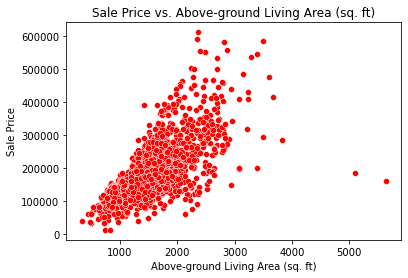

In [767]:
#Outlier identification - Using gr_liv_area (above ground sq ft) as a proxy for total square foot of home
#                         (assuming that the relationship between sq ft and price should be reasonably linear)

sns.scatterplot(x = train['gr_liv_area'],
                y= train['saleprice'],
                color = 'red');
plt.xlabel('Above-ground Living Area (sq. ft)')
plt.ylabel('Sale Price')
plt.title('Sale Price vs. Above-ground Living Area (sq. ft)')

#Only outliers seem to be the two all the way to the right - we can cut these out of the dataset.

train = train[train['gr_liv_area'] < 4500]

Text(0.5, 1.0, 'Sale Price vs. Above-ground Living Area (sq. ft)')

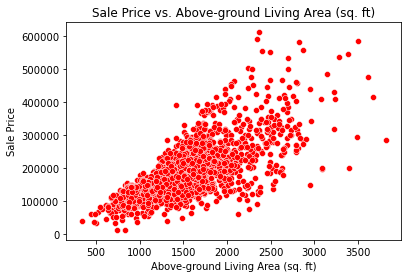

In [768]:
#Now plotting with outliers removed.

sns.scatterplot(x = train['gr_liv_area'],
                y= train['saleprice'],
                color = 'red');
plt.xlabel('Above-ground Living Area (sq. ft)')
plt.ylabel('Sale Price')
plt.title('Sale Price vs. Above-ground Living Area (sq. ft)')

#Better!

In [769]:
#Column 'MS Subclass' is a categorical variable, but is currently a int dtype - let's change that:
train['ms_subclass'] = train['ms_subclass'].map(lambda x: str(x))

#The Mo Sold column can also be better described by replacing integers with their corresponding months.
train['mo_sold'].replace({1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep',
                          10: 'oct', 11: 'nov', 12: 'dec'}, inplace = True)

In [770]:
#Repeating above cleaning but for test set:
test['ms_subclass'] = test['ms_subclass'].map(lambda x: str(x))

test['mo_sold'].replace({1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep',
                          10: 'oct', 11: 'nov', 12: 'dec'}, inplace = True)

## Feature Engineering

In [771]:
#Interaction Terms - starting with ones done easily by hand (combining quals + conds)
train['overallcomb'] = train.overall_qual * train.overall_cond

train.bsmt_qual = train.bsmt_qual.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train.bsmt_cond = train.bsmt_cond.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train['bsmtcomb'] = train.bsmt_qual * train.bsmt_cond

train.garage_qual = train.garage_qual.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train.garage_cond = train.garage_cond.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train['garagecomb'] = train.garage_qual * train.garage_cond

train.exter_qual = train.exter_qual.map({ 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train.exter_cond = train.exter_cond.map({ 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train['extercomb'] = train.exter_qual * train.exter_cond

train['sfcomb'] = train.gr_liv_area + train.total_bsmt_sf

In [772]:
#Same as above, but for test set.
test['overallcomb'] = test.overall_qual * test.overall_cond

test.bsmt_qual = test.bsmt_qual.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test.bsmt_cond = test.bsmt_cond.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test['bsmtcomb'] = test.bsmt_qual * test.bsmt_cond

test.garage_qual = test.garage_qual.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test.garage_cond = test.garage_cond.map({'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test['garagecomb'] = test.garage_qual * test.garage_cond

test.exter_qual = test.exter_qual.map({ 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test.exter_cond = test.exter_cond.map({ 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
test['extercomb'] = test.exter_qual * test.exter_cond

test['sfcomb'] = test.gr_liv_area + test.total_bsmt_sf

## Exploratory Data Analysis

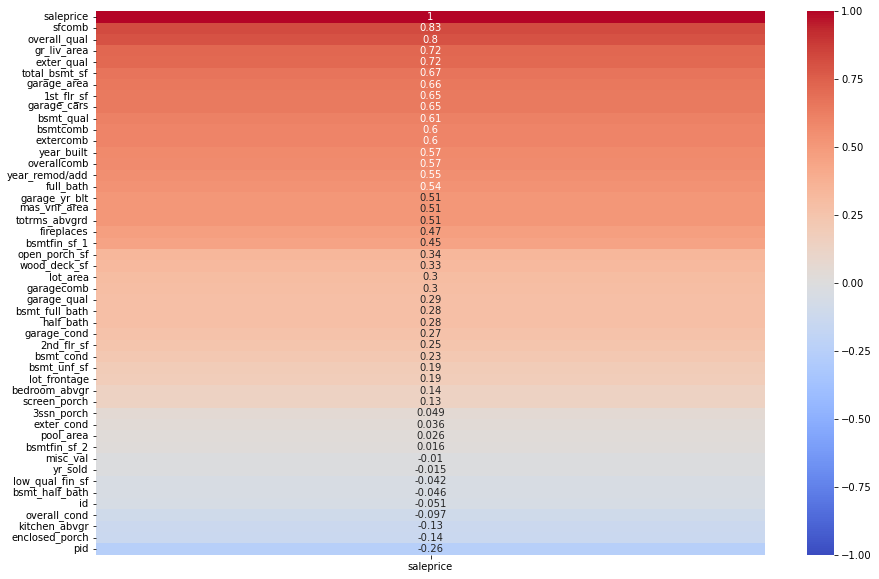

In [773]:
#First we will look for which variables have a significant correlation with price. 
corr = train.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr[['saleprice']].sort_values(by = 'saleprice', ascending = False), 
            annot = True,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm');

In [774]:
#The top 10 highest correlation coefficients with saleprice are below. These should prove useful for generating 
#interaciton terms. These could also be used for a more simple multi-linear regression
top_10 = ['sfcomb', 'overall_qual', 'gr_liv_area', 'exter_qual', 'total_bsmt_sf', 
          'garage_area', '1st_flr_sf', 'garage_cars', 'bsmt_qual', 'bsmtcomb']

#Choosing NOT to use PolynomialFeatures - Do not want excessive interaction terms leading to overfit model,
#going to instead keep it simple.

In [775]:
#Summary Statistics
train.describe()

,id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,screen_porch,pool_area,misc_val,yr_sold,saleprice,overallcomb,bsmtcomb,garagecomb,extercomb,sfcomb
count,2049.000000,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,1473.676428,7.134001e+08,57.785749,10024.677892,6.108346,5.562714,1971.673499,1984.166423,97.736945,3.404588,...,16.527574,2.165935,43.327965,2007.775988,181479.018058,33.850659,10.544656,8.367496,10.513909,2548.589068
std,844.248064,1.886859e+08,32.633866,6608.511749,1.421780,1.104897,30.171293,21.032785,171.936400,0.586134,...,57.399890,36.297124,434.481342,1.312533,79295.913255,9.246629,3.059482,2.331036,2.191721,766.978588
min,1.000000,5.263011e+08,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,2006.000000,12789.000000,1.000000,0.000000,0.000000,2.000000,334.000000
25%,753.000000,5.284581e+08,43.000000,7500.000000,5.000000,5.000000,1953.000000,1964.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,2007.000000,129800.000000,30.000000,9.000000,9.000000,9.000000,2010.000000
50%,1481.000000,5.354532e+08,63.000000,9405.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,2008.000000,162500.000000,35.000000,12.000000,9.000000,9.000000,2457.000000
75%,2199.000000,9.071760e+08,78.000000,11500.000000,7.000000,6.000000,2001.000000,2004.000000,158.000000,4.000000,...,0.000000,0.000000,0.000000,2009.000000,214000.000000,40.000000,12.000000,9.000000,12.000000,2996.000000
max,2930.000000,9.241520e+08,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.000000,...,490.000000,800.000000,12500.000000,2010.000000,611657.000000,90.000000,20.000000,25.000000,25.000000,6428.000000


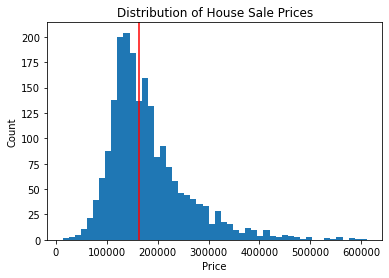

In [776]:
#### Visualizations - Distributions, etc.

plt.hist(train['saleprice'], bins = 50);
plt.axvline(train['saleprice'].median(), color = 'red')
plt.title('Distribution of House Sale Prices')
plt.xlabel('Price')
plt.ylabel('Count');

Above, one can see that the distribution of house sale prices in Ames isn't exactly normal, as a long right tail is present.

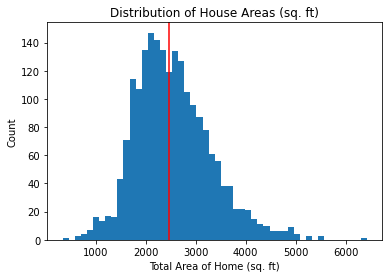

In [777]:
plt.hist(train['sfcomb'], bins = 50)
plt.axvline(train['sfcomb'].median(), color = 'red')
plt.title('Distribution of House Areas (sq. ft)')
plt.xlabel('Total Area of Home (sq. ft)')
plt.ylabel('Count');

Closer to normal distirbution than price. Median house size seems to be ~2,400 square feet. Very close to shape in price, possible relationship. 

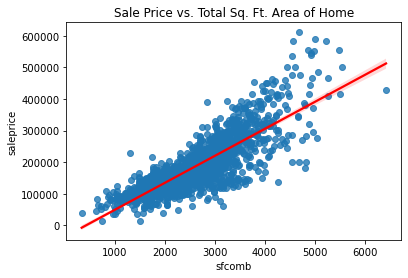

In [778]:
sns.regplot(x = train['sfcomb'],
            y = train['saleprice'],
            line_kws = {'color':'red'});
plt.title('Sale Price vs. Total Sq. Ft. Area of Home');

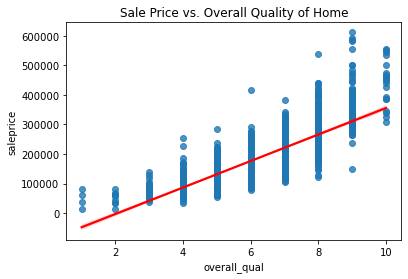

In [779]:
sns.regplot(x = train['overall_qual'],
            y = train['saleprice'],
            line_kws = {'color':'red'});
plt.title('Sale Price vs. Overall Quality of Home');

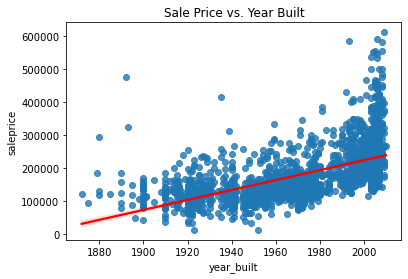

In [780]:
sns.regplot(x = train['year_built'],
             y = train['saleprice'],
             line_kws = {'color':'red'})
plt.title('Sale Price vs. Year Built');

Each of the regression plots above highlight the somewhat strong correlations these select features have with price. With year_built, although the regression line may be less fit, new houses can clearly be sold for much higher shown on the right side of the chart.

## Model Creation and Evaluation

Preprocessing - Here, categorical variables are dummified in each of the training and test sets, then we ensure that these sets have the same features list so that we can use sklearn on them. That is, the number of columns must match. The reason they may not have the same number of features initially is that either set may not have all possible dummy values present. These dataframes with dummy categorical variables are refered to as 'train_new' and 'test_new' for lack of better names.

In [781]:
print(f'Train / test set dimensions: {sizes}')

Train / test set dimensions: [(2051, 81), (878, 80)]


In [782]:
cat_feats = train.select_dtypes(include = ["object"]).columns
train1 = train.drop(columns = cat_feats)
train2 = train[cat_feats]

train2 = pd.get_dummies(train2)

train_new = pd.concat([train1, train2], axis = 1)

train_new.shape

(2049, 308)

In [783]:
cat_feats2 = test.select_dtypes(include = ["object"]).columns
test1 = test.drop(columns = cat_feats2)
test2 = test[cat_feats2]

test2 = pd.get_dummies(test2)

test_new = pd.concat([test1, test2], axis = 1)

test_new.shape

(878, 293)

In [784]:
#Here, differences in columns between the newly created train_new and test_new dataframes are recorded.
diffs = []
for x in list(test_new.columns):  #columns found in the test set, but not the training set.
    if x not in list(train_new.columns):
        diffs.append(x)

diffs

['roof_matl_Metal',
 'roof_matl_Roll',
 'exterior_1st_PreCast',
 'exterior_2nd_Other',
 'exterior_2nd_PreCast',
 'mas_vnr_type_CBlock',
 'heating_Floor',
 'kitchen_qual_Po',
 'sale_type_VWD']

In [785]:
test_new.drop(columns = diffs, inplace = True)

test_new.shape

(878, 284)

In [786]:
#Here we list the columns that are contained in the training set but not the test set.
diffs = []
for x in list(train_new.columns):
    if x not in list(test_new.columns):
        diffs.append(x)

diffs

['saleprice',
 'ms_subclass_150',
 'ms_zoning_A (agr)',
 'utilities_NoSeWa',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'condition_2_Artery',
 'condition_2_PosN',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran',
 'exterior_1st_CBlock',
 'exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'exterior_2nd_Stone',
 'heating_OthW',
 'heating_Wall',
 'heating_qc_Po',
 'functional_Sal',
 'functional_Sev',
 'pool_qc_Fa',
 'pool_qc_Gd',
 'misc_feature_TenC']

In [787]:
train_new.drop(columns = diffs[1:], inplace = True)

train_new.shape

(2049, 285)

Now the full, dummified dataframes (with matching feature lists) are ready. Below, the training set is itself split into a training and test set. The test set cleaned above will be used for final evaluation of the models. It will be called as test_new, as defined above.

In [788]:
#Train-test-split
train_new.rename(columns = {'id': 'Id'}, inplace = True)
test_new.rename(columns = {'id': 'Id'}, inplace = True)

X = train_new.drop(['saleprice'], axis = 'columns')
y = train_new.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape

(1639, 284)

First model construction - a multiple regression using all independent variables possible

In [789]:
#Unscaled - Multiple regression model using all features possible (including categorical variables).

lr = LinearRegression()

lr.fit(X_train, y_train)

print(f'Training Score: {lr.score(X_train, y_train)}')
print(f'Testing Score: {lr.score(X_test, y_test)}') #Scores already good w/o scaling or Ridge

Training Score: 0.939853208938008
Testing Score: 0.9262965565495891


In [790]:

preds = lr.predict(test_new)

test_new['SalePrice'] = preds

lr_submission = test_new[['Id', 'SalePrice']]

lr_submission.set_index('Id', inplace = True)

In [791]:
lr_submission.to_csv('../model-submissions/lr_model_all.csv')

test_new.drop(columns = 'SalePrice', inplace = True)

lr_submission.head()

,SalePrice
Id,
2658,144177.645674
2718,156030.446956
2414,214657.033917
1989,117056.724359
625,179408.170969


Multiple regression model using all possible independent variables saved. Now will look at a model using Ridge cross-validation.

In [792]:
#Scaling - as required for use in Ridge regularization. 
ss = StandardScaler()

Z_train = ss.fit_transform(X_train)

Z_test = ss.transform(X_test)

#Also scaling the test set so that the model can run on it.
test_new_sc = ss.transform(test_new)

In [793]:
#RidgeCV -- Taken from Lesson 4.03
alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = alphas, cv = 5)
# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [794]:
(ridge_cv.alpha_, ridge_cv.best_score_)

(298.364724028334, 0.9102557151947727)

In [795]:
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))

0.9342181735167562
0.9218697494849822


In [796]:
preds = ridge_cv.predict(test_new_sc)

test_new['SalePrice'] = preds

test_new.rename(columns = {'id':'Id'}, inplace = True)

ridge_submission = test_new[['Id', 'SalePrice']]

ridge_submission.set_index('Id', inplace = True)

In [797]:
ridge_submission.to_csv('../model-submissions/ridge_cv_model.csv')

test_new.drop(columns = 'SalePrice', inplace = True)

ridge_submission.head()

,SalePrice
Id,
2658,142413.906137
2718,161599.331223
2414,220378.170718
1989,114071.464573
625,182373.845182


Ridge cross-validation model complete and saved. Now a Lasso regression model will be explored:

In [798]:
#From Lesson 4.03:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas = l_alphas)
# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train)

/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175646715659.6068, tolerance: 810995895.1510522
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67602765497.91388, tolerance: 810995895.1510522
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65190003920.1048, tolerance: 810995895.1510522
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyleness/opt/ana

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [799]:
print(f'Training score: {lasso_cv.score(Z_train, y_train)}')
print(f'Testing score: {lasso_cv.score(Z_test, y_test)}')

Training score: 0.939830252575859
Testing score: 0.9260112267143599


In [800]:
preds = lasso_cv.predict(test_new_sc)

test_new['SalePrice'] = preds

lasso_submission = test_new[['Id', 'SalePrice']]

lasso_submission.set_index('Id', inplace = True)

In [801]:
lasso_submission.to_csv('../model-submissions/lasso_cv_model.csv')

lasso_submission.head()

,SalePrice
Id,
2658,143758.895004
2718,156290.325102
2414,214687.278805
1989,117203.398543
625,179337.579389


Finally, we will look at a more simple multiple regression model using the top 10 features most significantly correlated to sale price, as observed above in the heatmap shown previously.

In [802]:
#Here the original train dataframe is being used because the categorical features are not being used. 
X_top10 = train[top_10]
y_top10 = train['saleprice']

X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y_top10, test_size = 0.2, random_state = 42)

In [803]:
top10 = LinearRegression()

top10.fit(X_train_top10, y_train_top10)

LinearRegression()

In [804]:
print(f'Training Score: {top10.score(X_train_top10, y_train_top10)}')
print(f'Testing Score: {top10.score(X_test_top10, y_test_top10)}')

Training Score: 0.8390398819740101
Testing Score: 0.8344471015909346


In [805]:
preds = top10.predict(test[top_10])

test['SalePrice'] = preds

test.rename(columns = {'id':'Id'}, inplace = True)

top10_submission = test[['Id', 'SalePrice']]

top10_submission.set_index('Id', inplace = True)

In [806]:
top10_submission.to_csv('../model-submissions/top10_model.csv')

top10_submission.head()

,SalePrice
Id,
2658,170635.722426
2718,225621.653967
2414,200558.113725
1989,145369.015846
625,182537.071491


All models above perform significantly better than a baseline (saleprice set to median) model given that their R-squared values are well over 0. This exploration can be deemed successful. 

The best performing model is the first one explored - unscaled multiple regression using all independent variables possible. This model works by finding the ordinary least squares line of best fit for the collection of datapoints in the training set. Plotting this would be difficult (requiring 3D space), but the model is essentially the line that most minimizes the sum of squared residuals (residuals being the distance of the predicted values from the actual values) in the 3D feature space. Using this model then on the training set should yield some accurate predictions.

Note: With well over 200 independent variables used in the first three models, inference from model coefficients is very difficult (especially if scaled).

## Conclusions and Recommendations

Out of the four models explored in this analysis, the first multiple regression model incorporating all possible features shared between the train and test sets without any use of scaling appears to perform the best, albeit by a very slight margin over the Lasso CV and Ridge CV models. These models may rank differently using an evaluation metric besides R-squared, but this was not looked into. So, if there is a homeowner in need of help with their valuation, they should be referred to this unscaled multiple regression model. Any of the models created and tested herein would be of better use to a homeowner than simply assuming median sale price (baseline). 

As for recommendations / insights from this data specifically, some of the most important factors in improving sale price for a home seem to be the total area of the home in square feet, the overall quality of the home, the exterior design / maintenance, the size and car capacity of the garage, and how new the house is. Some of these were anticipated in the problem statement. Alas, if a homeowner is aiming to increase the sale value of their home, they should focus most on improving their standing in these features. For example, adding an extension to the house would very likely add value to the home. 

In the future, analysis should be done to see how much value each type of renovation adds to a home's resale value net renovation-related expenses. Such analysis would show what renovations offer the best return on investment for a homeowner. This information would be essential if the renovations are being done solely to boost resale value.